<a href="https://colab.research.google.com/github/leeyuuj/Deep-Learning-portfolio/blob/main/Tensorflow/4.Introduction%20to%20gradients%20and%20automatic%20differentiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction to gradients and automatic differentiation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/autodiff"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/autodiff.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/autodiff.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/autodiff.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Automatic Differentiation and Gradients

[Automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)
is useful for implementing machine learning algorithms such as
[backpropagation](https://en.wikipedia.org/wiki/Backpropagation) for training
neural networks.

In this guide, you will explore ways to compute gradients with TensorFlow, especially in eager execution.

자동 미분 및 그래디언트

[자동 미분](https://en.wikipedia.org/wiki/Automatic_differentiation)은 신경망 학습을 위한 [역전파](https://en.wikipedia.org/wiki/Backpropagation)와 같은 머신러닝 알고리즘을 구현하는 데 유용합니다.

이 가이드에서는 특히 [즉시 실행](eager.ipynb)에서 TensorFlow로 그래디언트를 계산하는 방법을 알아봅니다.

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## Computing gradients

To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the *forward* pass.  Then, during the *backward pass*, TensorFlow traverses this list of operations in reverse order to compute gradients.

그래디언트 계산하기

자동으로 미분하기 위해 TensorFlow는 *정방향 패스* 동안 어떤 연산이 어떤 순서로 발생하는지 기억해야 합니다. 그런 다음 *역방향 패스* 동안 TensorFlow는 이 Ops 목록을 역순으로 이동하여 그래디언트를 계산합니다.

## Gradient tapes

TensorFlow provides the `tf.GradientTape` API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually `tf.Variable`s.
TensorFlow "records" relevant operations executed inside the context of a `tf.GradientTape` onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using [reverse mode differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).

Here is a simple example:

그래디언트 테이프

텐서플로는 자동 미분(주어진 입력 변수에 대한 연산의 그래디언트(gradient)를 계산하는 것)을 위한 [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) API를 제공합니다. `tf.GradientTape`는 컨텍스트(context) 안에서 실행된 모든 연산을 테이프(tape)에 "기록"합니다. 그 다음 텐서플로는 [후진 방식 자동 미분(reverse mode differentiation)](https://en.wikipedia.org/wiki/Automatic_differentiation)을 사용해 테이프에 "기록된" 연산의 그래디언트를 계산합니다.

예를 들면:

In [ ]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:           # persistence = False : 휘발성 한번쓰면 저장안하기때문에 두번째쓸때 error남
  y = x**2                                # context(문맥) : tape에 기록한다   forward prop

Once you've recorded some operations, use `GradientTape.gradient(target, sources)` to calculate the gradient of some target (often a loss) relative to some source (often the model's variables):

일부 연산을 기록한 후에는 `GradientTape.gradient(target, sources)`를 사용하여 일부 소스(종종 모델 변수)에 상대적인 일부 대상(종종 손실)의 그래디언트를 계산합니다.

In [ ]:
# dy = 2x * dx
dy_dx = tape.gradient(y, x)         # 호출하면 GradientTape 종료됨
dy_dx.numpy()                       # print(dy_dx.numpy()) => 6.0  출력             # type(dy_dx.numpy()) = <class 'numpy.float32'>
print(dy_dx)                        # 리턴값 텐서                                   # type(dy_dx) = <class 'tensorflow.python.framework.ops.EagerTensor'>>

tf.Tensor(6.0, shape=(), dtype=float32)


In [ ]:
dy_dx = tape.gradient(y, x)                     # A non-persistent

RuntimeError: ignored

The above example uses scalars, but `tf.GradientTape` works as easily on any tensor:

위의 예제는 스칼라(소스가 스칼라)를 사용하지만, `tf.GradientTape`는 모든 텐서에서 쉽게 작동합니다.

In [ ]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')             # (3,2)array의 정규분포값 
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:                  # persistent(영속성) = True : 비휘발성 (계속 유지한다), default : False
  y = x @ w + b                                                 # ops : @, +
  loss = tf.reduce_mean(y**2)                                   #       reduce_mean : 평균값구하는 함수

To get the gradient of `loss` with respect to both variables, you can pass both as sources to the `gradient` method. The tape is flexible about how sources are passed and will accept any nested combination of lists or dictionaries and return the gradient structured the same way (see `tf.nest`).

두 변수 모두에 대해 `loss`의 그래디언트를 가져오려면, 두 변수를 `gradient `메서드에 소스로 전달할 수 있습니다. 테이프는 소스가 전달되는 방식에 대해 융통성이 있으며 list 또는 dictionaries의 중첩된 조합을 허용하고 같은 방식으로 구조화된 그래디언트를 반환합니다(`tf.nest` 참조).

In [ ]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])                # [w, b] :소스

print(dl_dw)
print(dl_db)

tf.Tensor(
[[ 0.9190074  3.341651 ]
 [ 1.8380148  6.683302 ]
 [ 2.7570224 10.024953 ]], shape=(3, 2), dtype=float32)
tf.Tensor([0.9190074 3.341651 ], shape=(2,), dtype=float32)


The gradient with respect to each source has the shape of the source:

In [ ]:
print(w.shape)
print(dl_dw.shape)

(3, 2)
(3, 2)


Here is the gradient calculation again, this time passing a dictionary of variables:

In [ ]:
my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars)
print(grad['w'])
print(grad['b'])

tf.Tensor(
[[-0.45082402  3.4077132 ]
 [-0.90164804  6.8154263 ]
 [-1.3524721  10.22314   ]], shape=(3, 2), dtype=float32)
tf.Tensor([-0.45082402  3.4077132 ], shape=(2,), dtype=float32)


In [ ]:
del tape      # 호출한후 날리기

grad = tape.gradient(loss, my_vars)

NameError: ignored

## Gradients with respect to a model

It's common to collect `tf.Variables` into a `tf.Module` or one of its subclasses (`layers.Layer`, `keras.Model`) for [checkpointing](checkpoint.ipynb) and [exporting](saved_model.ipynb).

In most cases, you will want to calculate gradients with respect to a model's trainable variables.  Since all subclasses of `tf.Module` aggregate their variables in the `Module.trainable_variables` property, you can calculate these gradients in a few lines of code: 

검사점 설정 및 내보내기를 위해 `tf.Variables`를 `tf.Module` 또는 해당 서브 클래스(`layers.Layer`와 `keras.Model`) 중 하나로 수집하는 것이 일반적입니다.

대부분의 경우 모델의 훈련 가능한 변수에 대한 그래디언트를 계산하려고 합니다. `tf.Module`의 모든 서브 클래스는 `Module.trainable_variables` 속성에서 변수를 집계하므로 몇 줄의 코드로 이러한 그래디언트를 계산할 수 있습니다.

소스: 클래스인 경우

In [ ]:
layer = tf.keras.layers.Dense(2, activation='relu')   # Dense는 keras에서 지원해주는 hidden layer[Full connected layer] , hidden layer에 노드 2개
# 현재 layer의 weight 파라미터의 갯수를 알수있는가? 모름
# 그러나 bias의 갯수는 알 수 있다. => 노드 2개니까 2개


x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)          # 파라미터 2*3 = 6개      # 레이어 : 콜러블 객체
  # 이제 layer의 weight 파라미터 갯수를 알 수 있다.
  loss = tf.reduce_mean(y**2)

In [ ]:
print(layer.trainable_variables)      # kernel : weight  bias : 초기화 0, 0 

[<tf.Variable 'dense_5/kernel:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.0034107 , -0.05221558],
       [ 0.12703133,  0.31041837],
       [ 0.29805863,  0.30371845]], dtype=float32)>, <tf.Variable 'dense_5/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]


In [ ]:
# layer.trainable = False    # Gradient Tape context 외부에서 설정을 해도 적용이 된다.

In [ ]:
# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)             # Dense:6개를 trainable_variables로 weight parameter를 퉁친다
print(grad)

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.6713717, 0.       ],
       [1.3427434, 0.       ],
       [2.014115 , 0.       ]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.6713717, 0.       ], dtype=float32)>]


In [ ]:
for var, g in zip(layer.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}')                  # kernel을 weight로 생각하면 된다.

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


### zip() 기본 문법

zip() 함수는 여러 개의 순회 가능한(iterable) 객체를 인자로 받고, 각 객체가 담고 있는 원소를 tuple의 형태로 차례로 접근할 수 있는 반복자(iterator)를 반환

In [ ]:
numbers = [1, 2, 3]
letters = ["A", "B", "C"]
for pair in zip(numbers, letters):
  print(pair)

(1, 'A')
(2, 'B')
(3, 'C')


In [ ]:
for var, g in zip(layer.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}')

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


<a id="watches"></a>

## Controlling what the tape watches  (기록전 감시한다)

The default behavior is to record all operations after accessing a trainable `tf.Variable`. The reasons for this are:

* The tape needs to know which operations to record in the forward pass to calculate the gradients in the backwards pass.
* The tape holds references to intermediate outputs, so you don't want to record unnecessary operations.
* The most common use case involves calculating the gradient of a loss with respect to all a model's trainable variables.

For example, the following fails to calculate a gradient because the `tf.Tensor` is not "watched" by default, and the `tf.Variable` is not trainable:

기본 동작은 훈련 가능한 `tf.Variable`에 액세스한 후 모든 Ops을 기록하는 것입니다. 그 이유는 다음과 같습니다.

- 테이프는 역방향 패스의 기울기를 계산하기 위해 정방향 패스에 기록할 Ops을 알아야 합니다.
- 테이프는 중간 출력에 대한 참조를 보유하므로 불필요한 Ops을 기록하지 않습니다.
- 가장 일반적인 사용 사례는 모든 모델의 훈련 가능한 변수에 대해 loss의 기울기를 계산하는 것입니다.

예를 들어, 다음은 `tf.Tensor`가 기본적으로 "감시"되지 않고 `tf.Variable`의 `trainable` 속성이 `False`이기 때문에 그래디언트를 계산하지 못합니다.

In [ ]:
# A trainable variable
x0 = tf.Variable(3.0, name='x0')                          # trainable=True watch

# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)         # immutable
print("x1=", x1)

# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0                    # 1.0 더하는순간 tensor 객체가 되고 immutable이기때문에 감시대상이 안됨
print("x2=", x2)

# Not a variable
x3 = tf.constant(3.0, name='x3')
print("x3=", x3)


x1= <tf.Variable 'x1:0' shape=() dtype=float32, numpy=3.0>
x2= tf.Tensor(3.0, shape=(), dtype=float32)
x3= tf.Tensor(3.0, shape=(), dtype=float32)


In [ ]:
with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print("g = ", g)

g =  tf.Tensor(6.0, shape=(), dtype=float32)
g =  None
g =  None
g =  None


You can list the variables being watched by the tape using the `GradientTape.watched_variables` method:

`GradientTape.watched_variables` 메서드를 사용하여 테이프에서 감시 중인 변수를 나열할 수 있습니다.

In [ ]:
[var.name for var in tape.watched_variables()]        # 감시대상 타겟이되는걸 조회

['x0:0']

`tf.GradientTape` provides hooks that give the user control over what is or is not watched.

To record gradients with respect to a `tf.Tensor`, you need to call `GradientTape.watch(x)`:

`tf.GradientTape`는 사용자가 감시 대상 또는 감시 예외 대상을 제어할 수 있는 후크를 제공합니다.

`tf.Tensor`에 대한 그래디언트를 기록하려면 `GradientTape.watch(x)`를 호출해야 합니다.

In [ ]:
x = tf.constant(3.0)                  # 텐서라서 감시대상이 아닌데 
with tf.GradientTape() as tape:
  tape.watch(x)                       # tape.watch(x)를 기록함으로 감시대상으로 만들수있다, GradientTape의 watched_variables 속성에 반영되지 않는다.
  y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

6.0


In [ ]:
x = tf.constant(3.0)                
with tf.GradientTape() as tape:
  y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx)

None


Conversely, to disable the default behavior of watching all `tf.Variables`, set `watch_accessed_variables=False` when creating the gradient tape. This calculation uses two variables, but only connects the gradient for one of the variables:

반대로, 모든 `tf.Variables`을 감시하는 기본 동작을 비활성화하려면, 그래디언트 테이프를 만들 때 `watch_accessed_variables=False`를 설정합니다. 이 계산은 두 가지 변수를 사용하지만, 변수 중 하나의 그래디언트만 연결합니다.

In [ ]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:         # 감시대상인데 access 못하게
  tape.watch(x1)                                                      # x1만 값이나옴
  y0 = tf.math.sin(x0)
  y1 = tf.nn.softplus(x1)
  y = y0 + y1
  ys = tf.reduce_sum(y)

Since `GradientTape.watch` was not called on `x0`, no gradient is computed with respect to it:

`x0`에서 `GradientTape.watch`가 호출되지 않았으므로 이에 대한 그래디언트가 계산되지 않습니다.

In [ ]:
# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'])
# print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: tf.Tensor(0.9999546, shape=(), dtype=float32)


## Intermediate results

You can also request gradients of the output with respect to intermediate values computed inside the `tf.GradientTape` context.

`tf.GradientTape` 컨텍스트 내에서 계산된 중간값과 관련하여 출력의 그래디언트를 요청할 수도 있습니다.

In [ ]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x               # y is intermediate value
  z = y * y               # y **2 -> 2y

# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())

18.0


By default, the resources held by a `GradientTape` are released as soon as the `GradientTape.gradient` method is called. To compute multiple gradients over the same computation, create a gradient tape with `persistent=True`. This allows multiple calls to the `gradient` method as resources are released when the tape object is garbage collected. For example:

기본적으로, `GradientTape.gradient` 메서드가 호출되면 `GradientTape`가 보유한 리소스가 해제됩니다. 동일한 계산에 대해 여러 그래디언트를 계산하려면 `persistent=True` 그래디언트 테이프를 만듭니다. 이렇게 하면 테이프 객체가 가비지 수집될 때 리소스가 해제되면 `gradient` 메서드를 여러 번 호출할 수 있습니다. 예를 들면 다음과 같습니다.

In [ ]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())  # [4.0, 108.0] (4 * x**3 at x = [1.0, 3.0])
print(tape.gradient(y, x).numpy())  # [2.0, 6.0] (2 * x at x = [1.0, 3.0])

[  4. 108.]
[2. 6.]


In [ ]:
del tape   # Drop the reference to the tape

## Notes on performance

* There is a tiny overhead associated with doing operations inside a gradient tape context. For most eager execution this will not be a noticeable cost, but you should still use tape context around the areas only where it is required.

* Gradient tapes use memory to store intermediate results, including inputs and outputs, for use during the backwards pass.

  For efficiency, some ops (like `ReLU`) don't need to keep their intermediate results and they are pruned during the forward pass. However, if you use `persistent=True` on your tape, *nothing is discarded* and your peak memory usage will be higher.

- 그래디언트 테이프 컨텍스트 내에서 Ops을 수행하는 것과 관련하여 작은 오버헤드가 있습니다. 대부분의 Eager 실행에는 상당한 비용이 들지 않지만, 필요한 경우에만 테이프 컨텍스트를 사용해야 합니다.

- 그래디언트 테이프는 메모리를 사용하여 backwards pass 동안 사용하기 위해 입력 및 출력을 포함한 중간 결과(forward동안 생성된 값:activation 값)를 저장합니다. 

    효율성을 위해 (`ReLU`와 같은) 일부 연산은 중간 결과를 유지할 필요가 없으며 정방향 패스 동안에 정리됩니다. 그러나 테이프에서 `persistent=True`를 사용하면 *아무것도 삭제되지 않으며* 최대 메모리 사용량이 높아집니다.

## Gradients of non-scalar targets

A gradient is fundamentally an operation on a scalar.

그래디언트는 기본적으로 스칼라에 대한 연산입니다.

In [ ]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


Thus, if you ask for the gradient of multiple targets, the result for each source is:

* The gradient of the sum of the targets, or equivalently
* The sum of the gradients of each target.

따라서, 여러 대상의 그래디언트를 요청하면 각 소스의 결과는 다음과 같습니다.

* 대상의 합계 또는 그에 상응하는 그래디언트
* 각 대상의 그래디언트의 합계

아래 코드에서 non-scalar targets은</br>
{'y0': y0, 'y1': y1}을 의미한다

In [ ]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

3.75


Similarly, if the target(s) are not scalar the gradient of the sum is calculated:

마찬가지로, 대상이 스칼라가 아닌 경우 합계의 그래디언트가 계산됩니다.

In [ ]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.]            # [3., 4.]x, y' = [3., 4.]

print(tape.gradient(y, x).numpy())

7.0


This makes it simple to take the gradient of the sum of a collection of losses, or the gradient of the sum of an element-wise loss calculation.

If you need a separate gradient for each item, refer to [Jacobians](advanced_autodiff.ipynb#jacobians).

이렇게 하면, 손실 모음 합계의 기울기(비용함수) 또는 요소별 손실 계산 합계의 그래디언트를 간단하게 구할 수 있습니다.

각 항목에 대해 별도의 그래디언트가 필요한 경우, [Jacobians](advanced_autodiff.ipynb#jacobians)을 참조하세요.

In some cases you can skip the Jacobian. For an element-wise calculation, the gradient of the sum gives the derivative of each element with respect to its input-element, since each element is independent:

어떤 경우에는 쟈코비안을 건너뛸 수 있습니다. 요소별 계산의 경우, 각 요소가 독립적이므로 합의 그래디언트는 입력 요소와 관련하여 각 요소의 미분을 제공합니다.

In [ ]:
x = tf.linspace(-10.0, 10.0, 200+1)
print(x)      

tf.Tensor(
[-10.          -9.9         -9.8         -9.7         -9.6
  -9.5         -9.4         -9.3         -9.2         -9.1
  -9.          -8.9         -8.8         -8.7         -8.6
  -8.5         -8.4         -8.3         -8.2         -8.1
  -8.          -7.8999996   -7.8         -7.7         -7.6
  -7.5         -7.3999996   -7.3         -7.2         -7.1
  -7.          -6.8999996   -6.8         -6.7         -6.6
  -6.5         -6.3999996   -6.3         -6.2         -6.1
  -6.          -5.9         -5.7999997   -5.7         -5.6
  -5.5         -5.4         -5.2999997   -5.2         -5.1
  -5.          -4.9         -4.7999997   -4.7         -4.6
  -4.5         -4.4         -4.2999997   -4.2         -4.1
  -4.          -3.9         -3.7999997   -3.6999998   -3.6
  -3.5         -3.4         -3.2999997   -3.1999998   -3.1
  -3.          -2.9         -2.7999997   -2.6999998   -2.6
  -2.5         -2.4         -2.2999997   -2.1999998   -2.1
  -2.          -1.8999996   -1.8000002   -1.6

In [ ]:
with tf.GradientTape() as tape:
  tape.watch(x)                 
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)
print(dy_dx)

tf.Tensor(
[4.53978682e-05 5.01721843e-05 5.54485159e-05 6.12797521e-05
 6.77241260e-05 7.48462262e-05 8.27172553e-05 9.14158591e-05
 1.01029218e-04 1.11653302e-04 1.23366393e-04 1.36356830e-04
 1.50717431e-04 1.66567232e-04 1.83995464e-04 2.03419055e-04
 2.24778167e-04 2.48400233e-04 2.74463615e-04 3.03444540e-04
 3.35312623e-04 3.70424765e-04 4.09375789e-04 4.52432781e-04
 4.99952002e-04 5.52467944e-04 6.10485091e-04 6.74626499e-04
 7.45455211e-04 8.23741953e-04 9.10226954e-04 1.00573874e-03
 1.11131265e-03 1.22789398e-03 1.35669333e-03 1.49891921e-03
 1.65598630e-03 1.82954292e-03 2.02120445e-03 2.23287800e-03
 2.46652518e-03 2.72445590e-03 3.00932792e-03 3.32372868e-03
 3.67067871e-03 4.05359641e-03 4.47605969e-03 4.94212657e-03
 5.45618078e-03 6.02310384e-03 6.64812140e-03 7.33690709e-03
 8.09593033e-03 8.93205591e-03 9.85276140e-03 1.08662415e-02
 1.19813727e-02 1.32077541e-02 1.45557811e-02 1.60367247e-02
 1.76627338e-02 1.94466617e-02 2.14024633e-02 2.35448945e-02
 2.58895922e-

In [ ]:
sdev = tf.nn.sigmoide(x)

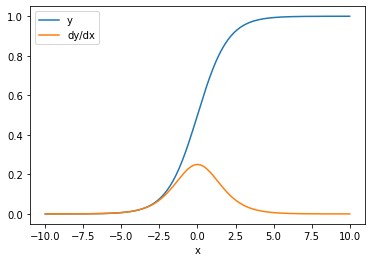

In [ ]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

## Control flow

Because a gradient tape records operations as they are executed, Python control flow is naturally handled (for example, `if` and `while` statements).

Here a different variable is used on each branch of an `if`. The gradient only connects to the variable that was used:

그래디언트 테이프는 실행되는 연산을 기록하기 때문에 Python 제어 흐름이 자연스럽게 처리됩니다(예: `if` 및 `while` 구문).

여기서는 `if`의 각 분기에 서로 다른 변수가 사용됩니다. 그래디언트는 사용된 변수에만 연결됩니다.

In [ ]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  if x > 0.0:
    result = v0
  else:
    result = v1**2 

dv0, dv1 = tape.gradient(result, [v0, v1])

print("dv0 =", dv0)
print("dv1 =", dv1)            # else구문은 실행이 안되기때문에 미분할수없어서 None값 나옴

dv0 = tf.Tensor(1.0, shape=(), dtype=float32)
dv1 = None


Just remember that the control statements themselves are not differentiable, so they are invisible to gradient-based optimizers.

Depending on the value of `x` in the above example, the tape either records `result = v0` or `result = v1**2`. The gradient with respect to `x` is always `None`.

제어문 자체는 미분할 수 없으므로 그래디언트 기반 최적화 프로그램에는 보이지 않습니다.

위 예제에서 `x` 값에 따라 테이프는 `result = v0` 또는 `result = v1**2`를 기록합니다. x에 대한 그래디언트는 항상 `None`입니다.

In [ ]:
dx = tape.gradient(result, x)

print(dx)

None


## Cases where `gradient` returns `None`

When a target is not connected to a source, `gradient` will return `None`.


target이 소스에 연결되어 있지 않으면 그래디언트는 `None`을 반환합니다.

In [ ]:
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y * y

  
print(tape.gradient(z, x))

None


Here `z` is obviously not connected to `x`, but there are several less-obvious ways that a gradient can be disconnected.

여기서 `z`는 명확하게 `x`에 연결되어 있지 않지만, 그래디언트의 연결을 끊을 수 있는 몇 가지 덜 명확한 방법이 있습니다.

### 1. Replaced a variable with a tensor

In the section on ["controlling what the tape watches"](#watches) you saw that the tape will automatically watch a `tf.Variable` but not a `tf.Tensor`.

One common error is to inadvertently replace a `tf.Variable` with a `tf.Tensor`, instead of using `Variable.assign` to update the `tf.Variable`. Here is an example:

["테이프의 감시 대상 제어"](#watches) 섹션에서 테이프가 자동으로 `tf.Variable`을 감시하지만 `tf.Tensor`는 감시하지 않는 것을 살펴보았습니다.

한 가지 일반적인 오류는 `Variable.assign`를 사용하여 `tf.Variable`를 업데이트하는 대신 실수로 `tf.Variable`을 `tf.Tensor`로 대체하는 것입니다. 예를 들면, 다음과 같습니다.

In [ ]:
x = tf.Variable(2.0)

for epoch in range(2):
  with tf.GradientTape() as tape:
    y = x+1
    print("y=", y)

  print(type(x).__name__, ":", tape.gradient(y, x))

  print("*" * 60)
  x = x + 1   # This should be `x.assign_add(1)`
  print("x=",x)

y= tf.Tensor(3.0, shape=(), dtype=float32)
ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
************************************************************
x= tf.Tensor(3.0, shape=(), dtype=float32)
y= tf.Tensor(4.0, shape=(), dtype=float32)
EagerTensor : None
************************************************************
x= tf.Tensor(4.0, shape=(), dtype=float32)


### 2. Did calculations outside of TensorFlow

The tape can't record the gradient path if the calculation exits TensorFlow.
For example:

계산에서 TensorFlow를 종료하면 테이프가 그래디언트 경로를 기록할 수 없습니다. 예를 들면, 다음과 같습니다.

In [ ]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # This step is calculated with NumPy
  # y = tf.convert_to_tesor(np.mean(x2, axis=0))
  y = np.mean(x2, axis=0)

  # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
  # using `tf.convert_to_tensor`.
  y = tf.reduce_mean(y, axis=0)

print("tape.gradient(y, x) = ", tape.gradient(y, x))

tape.gradient(y, x) =  None


### 3. Took gradients through an integer or string

Integers and strings are not differentiable. If a calculation path uses these data types there will be no gradient.

Nobody expects strings to be differentiable, but it's easy to accidentally create an `int` constant or variable if you don't specify the `dtype`.

정수와 문자열은 구별할 수 없습니다. 계산 경로에서 이러한 데이터 유형을 사용하면 그래디언트는 없습니다.

아무도 문자열을 미분할 것으로 기대하지는 않지만, `dtype`을 지정하지 않으면 실수로 `int` 상수 또는 변수를 만들기 쉽습니다.

In [ ]:
x = tf.constant(10)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))

None


TensorFlow doesn't automatically cast between types, so, in practice, you'll often get a type error instead of a missing gradient.

### 4. Took gradients through a stateful object

State stops gradients. When you read from a stateful object, the tape can only observe the current state, not the history that lead to it.

A `tf.Tensor` is immutable. You can't change a tensor once it's created. It has a _value_, but no _state_. All the operations discussed so far are also stateless: the output of a `tf.matmul` only depends on its inputs.

A `tf.Variable` has internal state—its value. When you use the variable, the state is read. It's normal to calculate a gradient with respect to a variable, but the variable's state blocks gradient calculations from going farther back. For example:


State가 그래디언트를 중지합니다. stateful object 객체에서 읽을 때 테이프는 현재 상태만 볼 수 있으며 현재 상태에 이르게 된 기록은 볼 수 없습니다.

`tf.Tensor`는 변경할 수 없습니다. 텐서가 작성된 후에는 변경할 수 없습니다. *값*은 있지만 *상태는* 없습니다. 지금까지 논의된 모든 연산은 상태 비저장입니다. `tf.matmul`의 출력은 입력에만 의존합니다.

`tf.Variable`은 내부 상태와 값을 갖습니다. 변수를 사용하면 state를 read합니다. 변수와 관련하여 그래디언트를 계산하는 것이 일반적이지만, 변수의 state는 그래디언트 계산이 더 뒤로 가지 않도록 차단(x1.assign_add(x0))합니다. 예를 들어


> State : variable가 상태를 가지고 있다. 
> tensor는 상태를 저장하는게 없다.


In [ ]:
x0 = tf.Variable(3.0)                   # 값이 아니라 메모리주소를 가지고있는것
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
  # Update x1 = x1 + x0.                # x1 + x0은 메모리 주소
  # x1 = x1 + x0                        # record
  x1.assign_add(x0)                     # x0이 가리키고있는 메모리주소로가서 3.0이라는 값을 읽어온다. # 이때 뒤로 가지않도록 차단한다는말 -> 기록을 안한다.(not record)
  # The tape starts recording from x1.
  y = x1**2   # y = (x1 + x0)**2        


# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x0)         # 값을 읽었기때문에 

# This work.
# print(tape.gradient(y, x1)) 

None


**Similarly, `tf.data.Dataset` iterators and `tf.queue`s are stateful, and will stop all gradients on tensors that pass through them.**

마찬가지로, `tf.data.Dataset` 반복기(iterator)와 `tf.queue`는 상태 저장이며 이들을 통과하는 텐서의 모든 그래디언트를 중지합니다.

## No gradient registered

Some `tf.Operation`s are **registered as being non-differentiable** and will return `None`. Others have **no gradient registered**.

The `tf.raw_ops` page shows which low-level ops have gradients registered.

If you attempt to take a gradient through a float op that has no gradient registered the tape will throw an error instead of silently returning `None`. This way you know something has gone wrong.

For example, the `tf.image.adjust_contrast` function wraps `raw_ops.AdjustContrastv2`, which could have a gradient but the gradient is not implemented:


일부 `tf.Operation`는 **미분 불가능한 것으로 등록되어** `None`을 반환합니다. 다른 연산에는 **그래디언트가 등록되지 않았습니다**.

`tf.raw_ops` 페이지에는 그래디언트가 등록된 저수준 op가 표시됩니다.

그래디언트가 등록되지 않은 float op를 통해 그래디언트를 얻고자 시도하면 테이프가 자동으로 `None`을 반환하는 대신 오류가 발생합니다. 이렇게 하면 무언가 잘못되었다는 것을 알 수 있습니다.

예를 들어, `tf.image.adjust_contrast` 함수는 그래디언트를 가질 수 있지만 그래디언트는 구현되지 않은 `raw_ops.AdjustContrastv2`를 래핑합니다.


In [ ]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
  new_image = tf.image.adjust_contrast(image, delta)              # image.adjust_contrast : training data 전처리할 때 사용, 이미지 명암조절하는 함수, 미분대상X 

try:
  print(tape.gradient(new_image, [image, delta]))
  assert False   # This should not happen.
except LookupError as e:
  print(f'{type(e).__name__}: {e}')


LookupError: gradient registry has no entry for: AdjustContrastv2


If you need to differentiate through this op, you'll either need to implement the gradient and register it (using `tf.RegisterGradient`) or re-implement the function using other ops.

이 op를 통해 미분해야 하는 경우, 그래디언트를 구현하고 등록하거나(`tf.RegisterGradient` 사용) 다른 ops를 사용하여 함수를 다시 구현해야 합니다.

## Zeros instead of None

In some cases it would be convenient to get 0 instead of `None` for unconnected gradients.  You can decide what to return when you have unconnected gradients using the `unconnected_gradients` argument:

연결되지 않은 그래디언트의 경우 `None` 대신 0을 가져오는 것이 편리한 경우가 있습니다. 연결되지 않은 그래디언트가 있을 때 `unconnected_gradients` 인수를 사용하여 반환할 항목을 결정할 수 있습니다.

In [ ]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y**2
  
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)
